In [85]:
# LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from deap import base, creator, tools, algorithms
import pickle



In [86]:
if not os.path.exists('ResidualProducts'):
    os.makedirs('ResidualProducts')

In [87]:
def plot_histogram_with_binning(dataset, title="Histogram of Values", xlabel="Values", ylabel="Frequency", filename="filename.jpg"):
    """
    Creates a histogram for the data in the second column of the dataset.
    Performs sensible binning based on the range of values.

    Args:
        dataset (pd.DataFrame): Dataset with at least two columns: the first is the identifier,
                                the second is the value to plot.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    # Ensure the dataset has at least two columns
    if dataset.shape[1] < 2:
        raise ValueError("The dataset must have at least two columns.")

    # Extract values from the second column
    values = dataset.iloc[:, 1]

    # Determine the range of values
    min_val = values.min()
    max_val = values.max()

      # Determine bin size based on the range and data type
    range_span = max_val - min_val
    if values.apply(float.is_integer).all() and range_span <= 100:  # Suitable for integers with small range
        num_bins = int(range_span + 1)
    else:
        bin_size = 0.01 if range_span > 1 else range_span / 100  # Adapt bin size dynamically
        num_bins = max(int(range_span / bin_size), 1)  # Ensure at least 1 bin

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=num_bins, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(filename)

    # Show the plot
    plt.show()

In [88]:
def calculate_durations(directory):
    """
    This method calculates the durations of data recording for each CSV file in a given directory.
    It assumes that the data is sampled at 12.5 Hz and calculates the duration based on the number of rows in each file.
    Files named 'blank.csv' are ignored. The method returns a sorted DataFrame containing filenames and their respective durations.
    
    Args:
        directory (str): The path to the directory containing the CSV files.
    
    Returns:
        pandas.DataFrame: A DataFrame with two columns:
                          - 'File': The name of each processed CSV file.
                          - 'Duration': The calculated duration for each file (in seconds).
    """
    durations = []
    filenames = []

    # Iterate over all files in the directory
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            if not file.endswith("blank.csv"):
                filepath = os.path.join(directory, file)

                # Read the CSV file and count the number of rows
                try:
                    data = pd.read_csv(filepath)
                    duration = len(data) / 12.5  # Calculate duration based on 12.5 Hz sampling rate

                    # Store the result
                    durations.append(duration)
                    filenames.append(file)
                except Exception as e:
                    print(f"Error reading the file {file}: {e}")

    # Create a DataFrame with the results
    df = pd.DataFrame({
        'File': filenames,
        'Duration': durations
    })

    # Sort the DataFrame by duration in ascending order and reset the index
    df = df.sort_values(by='Duration', ascending=True).reset_index(drop=True)
    return df


In [89]:
def copy_files_from_dataframe(df, sourcedir, destinationdir):
    """
    Copies files listed in a DataFrame from a source directory to a destination directory.
    
    Args:
        df (pd.DataFrame): DataFrame containing the filenames to be copied.
        sourcedir (str): Path to the source directory.
        destinationdir (str): Path to the destination directory.
        'File' (str): Name of the column containing the filenames. Default: 'File'.
    
    Returns:
        None
    """
    if 'File' not in df.columns:
        raise ValueError(f"The column 'File' does not exist in the DataFrame.")
    
    # Create the destination directory if it does not exist
    if not os.path.exists(destinationdir):
        os.makedirs(destinationdir)
    
    # Counters for copied and missing files
    files_copied = 0
    files_missing = 0
    
    for file in df['File']:
        source_path = os.path.join(sourcedir, file)
        destination_path = os.path.join(destinationdir, file)
        
        if os.path.exists(source_path):
            shutil.copy2(source_path, destination_path)  # Copy while preserving metadata
            files_copied += 1
        else:
            print(f"File not found: {source_path}")
            files_missing += 1
    
    print(f"Operation completed: {files_copied} files copied, {files_missing} files missing.")


In [90]:
def plot_duration_distribution(durations_df):
    """
    This method generates a plot displaying the distribution of durations for trials.
    It plots the trial indices on the x-axis and their corresponding durations on the y-axis.
    Vertical lines mark the 5th and 95th percentiles, while horizontal lines indicate the corresponding durations.
    The plot is saved as a JPEG file and displayed.

    Args:
        durations_df (pandas.DataFrame): A DataFrame containing two columns:
                                         - 'index': The trial indices (implicit as DataFrame index).
                                         - 'Duration': The durations for each trial.
    """
    plt.figure(figsize=(12, 8))
    
    # Create a plot with trials on the x-axis and duration on the y-axis
    plt.plot(durations_df.index, durations_df['Duration'], marker=".", alpha=0.7)
    plt.yticks(range(int(durations_df['Duration'].min()), int(durations_df['Duration'].max()), 5))

    length = len(durations_df)
    dur_05 = int(length * 0.05)
    dur_95 = int(length * 0.95)

    # Find y-values corresponding to the vertical lines
    y_5th = durations_df['Duration'].iloc[dur_05]
    y_95th = durations_df['Duration'].iloc[dur_95]

    # Vertical line for the 5th percentile
    plt.axvline(x=dur_05, color='red', linestyle='--', label='5th-Percentile')
    
    # Vertical line for the 95th percentile
    plt.axvline(x=dur_95, color='red', linestyle='--', label='95th-Percentile')

    # Thin black horizontal lines
    plt.axhline(y=y_5th, color='black', linestyle='-', linewidth=0.7)
    plt.axhline(y=y_95th, color='black', linestyle='-', linewidth=0.7)

    plt.title("Trial Ascending Duration Plot", fontsize=16)
    plt.xlabel("Trial (enum)", fontsize=14)
    plt.ylabel("Duration (seconds)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Save and display the plot
    plt.savefig("ResidualProducts/Plot_Durate_Trials_Ordinate_RAW.jpg")
    plt.show()


In [91]:
def plot_duration_distribution_filtered(durations_df):
    """
    Plots the distribution of trial durations after filtering based on pupil confidence.
    
    Args:
        durations_df (pd.DataFrame): A DataFrame containing trial durations, indexed by trial number, with a 'Duration' column.
    
    Returns:
        None
    """
    plt.figure(figsize=(12, 8))
    
    # Plot trials on the x-axis and durations on the y-axis
    plt.plot(durations_df.index, durations_df['Duration'], marker=".", alpha=0.7)
    plt.yticks(range(int(durations_df['Duration'].min()), int(durations_df['Duration'].max()), 5))

    length = len(durations_df)
    dur_10 = int(length * 0.05)  # Calculate the 5th percentile index

    # Get the y-value corresponding to the 5th percentile line
    y_10th = durations_df['Duration'].iloc[dur_10]

    # Add a vertical line for the 5th percentile
    plt.axvline(x=dur_10, color='red', linestyle='--', label='5th Percentile')

    # Add a horizontal line at the y-value of the 5th percentile
    plt.axhline(y=y_10th, color='black', linestyle='-', linewidth=0.7)

    # Title and labels
    plt.title("Trial Ascending Duration Plot After Pupil-Confidence Cleaning", fontsize=16)
    plt.xlabel("Trial (enum)", fontsize=14)
    plt.ylabel("Duration (seconds)", fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Save and display the plot
    plt.savefig("ResidualProducts/Plot_Durations_Trials_Ascending_Filtered.jpg")
    plt.show()


In [92]:
def calculate_range_x(directory):
    """
    Calculates the range of the 'x' column for each CSV file in a specified directory.
    Caps the range at a maximum of 15 and outputs the results in a sorted CSV file.

    Args:
        directory (str): Path to the directory containing CSV files.

    Returns:
        pd.DataFrame: A DataFrame with two columns:
                      - 'File': The name of each processed CSV file.
                      - 'Range': The calculated range of the 'x' column for each file.
    """
    ranges = []
    filenames = []

    # Iterate through all files in the directory
    for file in os.listdir(directory):
        if file.endswith(".csv") and not file.endswith("blank.csv"):
            filepath = os.path.join(directory, file)

            # Read the CSV file and calculate the range of 'x'
            try:
                data = pd.read_csv(filepath)
                x_range = abs(data['x'].max() - data['x'].min())
                
                # Cap the range at a maximum of 15
                if x_range > 15:
                    x_range = 15
                
                # Store the result
                ranges.append(x_range)
                filenames.append(file)
                print(file)  # Log the processed file
            except Exception as e:
                print(f"Error reading file {file}: {e}")

    # Create a DataFrame with the results
    df = pd.DataFrame({
        'File': filenames,
        'Range': ranges
    })

    # Sort the DataFrame by range in ascending order and save to a CSV file
    df = df.sort_values(by='Range', ascending=True).reset_index(drop=True)
    df.to_csv("ResidualProducts/RangeOrderedTrials.csv", index=False)
    return df


In [93]:
def calculate_range_y(directory):
    """
    Calculates the range of the 'y' column for each CSV file in a specified directory.
    Caps the range at a maximum of 15 and outputs the results in a sorted CSV file.

    Args:
        directory (str): Path to the directory containing CSV files.

    Returns:
        pd.DataFrame: A DataFrame with two columns:
                      - 'File': The name of each processed CSV file.
                      - 'Range': The calculated range of the 'y' column for each file.
    """
    ranges = []
    filenames = []

    # Iterate through all files in the directory
    for file in os.listdir(directory):
        if file.endswith(".csv") and not file.endswith("blank.csv"):
            filepath = os.path.join(directory, file)

            # Read the CSV file and calculate the range of 'y'
            try:
                data = pd.read_csv(filepath)
                y_range = abs(data['y'].max() - data['y'].min())
                
                # Cap the range at a maximum of 15
                if y_range > 15:
                    y_range = 15
                
                # Store the result
                ranges.append(y_range)
                filenames.append(file)
                print(file)  # Log the processed file
            except Exception as e:
                print(f"Error reading file {file}: {e}")

    # Create a DataFrame with the results
    df = pd.DataFrame({
        'File': filenames,
        'Range': ranges
    })

    # Sort the DataFrame by range in ascending order and save to a CSV file
    df = df.sort_values(by='Range', ascending=True).reset_index(drop=True)
    df.to_csv("ResidualProducts/RangeOrderedTrials_Y.csv", index=False)
    return df


In [94]:
def plot_combined_range_distribution(ranges_df_x, ranges_df_y, threshold_x, threshold_y):
    """
    Plots the distribution of ranges for both 'x' and 'y' values for Files,
    and applies cuts based on the specified thresholds.

    Args:
        ranges_df_x (pd.DataFrame): DataFrame containing ranges of 'x' values.
        ranges_df_y (pd.DataFrame): DataFrame containing ranges of 'y' values.
        threshold_x (float): Threshold for cutting Files based on 'x' range.
        threshold_y (float): Threshold for cutting Files based on 'y' range.

    Returns:
        pd.DataFrame: DataFrame with Files categorized as kept or cut based on thresholds.
    """
    # Identify Files that exceed the thresholds
    cut_x = ranges_df_x[ranges_df_x['Range'] >= threshold_x]
    cut_y = ranges_df_y[ranges_df_y['Range'] >= threshold_y]

    # Files failing either x or y thresholds
    total_cut = pd.concat([cut_x, cut_y]).drop_duplicates()
    total_kept = ranges_df_x.merge(ranges_df_y, on='File').drop(total_cut.index, errors='ignore')

    # Plot x and y ranges with their thresholds
    plt.figure(figsize=(14, 8))
    
    # Plot x ranges
    plt.plot(ranges_df_x.index, ranges_df_x['Range'], label='X Range', marker=".", alpha=0.7, color='blue')
    plt.axhline(y=threshold_x, color='blue', linestyle='--', label=f'X Threshold ({threshold_x})')

    # Plot y ranges
    plt.plot(ranges_df_y.index, ranges_df_y['Range'], label='Y Range', marker=".", alpha=0.7, color='green')
    plt.axhline(y=threshold_y, color='green', linestyle='--', label=f'Y Threshold ({threshold_y})')

    # Add title and labels
    plt.title("Combined X and Y Range Distribution with Thresholds", fontsize=16)
    plt.xlabel("File (enum)", fontsize=14)
    plt.ylabel("Range", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Save and show plot
    plt.tight_layout()
    plt.savefig("ResidualProducts/Combined_Range_Distribution_X_Y_Thresholds.jpg")
    plt.show()

    # Summary
    print(f"Total Files: {len(ranges_df_x)}")
    print(f"Files cut by X threshold: {len(cut_x)}")
    print(f"Files cut by Y threshold: {len(cut_y)}")
    print(f"Total Files cut: {len(total_cut)}")
    print(f"Total Files kept: {len(total_kept)}")

    # Return categorized DataFrame
    return pd.concat([
        total_cut.assign(Status='Cut'),
        total_kept.assign(Status='Kept')
    ])


In [95]:
def calculate_fixations(df, max_dispersion=15, min_duration_points=4):
    """
    This method identifies fixations from eye-tracking data using a dispersion-based algorithm.
    It calculates fixation statistics, including duration and pupil diameter metrics.

    Args:
        df (pandas.DataFrame): Input DataFrame containing at least the following columns:
                               - 'x': X-coordinates of gaze points.
                               - 'y': Y-coordinates of gaze points.
                               - 'DIAM': Pupil diameter values.
        max_dispersion (float): The maximum allowed dispersion (in pixels or units) for a set of points to be considered a fixation.
        min_duration_points (int): The minimum number of points required for a valid fixation.

    Returns:
        list of tuples: A list of tuples where each tuple represents a fixation with the following values:
                        - fixation_x (float): Mean x-coordinate of the fixation.
                        - fixation_y (float): Mean y-coordinate of the fixation.
                        - duration_fix (float): Duration of the fixation in milliseconds (calculated based on 13Hz sampling).
                        - min_diam (float): Minimum pupil diameter during the fixation.
                        - max_diam (float): Maximum pupil diameter during the fixation.
                        - mean_diam (float): Mean pupil diameter during the fixation.
                        - std_diam (float): Standard deviation of pupil diameter during the fixation.
    """
    fixations = []
    start_index = 0

    while start_index < len(df):
        # Initialize the current fixation
        current_fixation = [df.iloc[start_index]]
        i = start_index + 1

        while i < len(df):
            # Add the current point to the fixation if dispersion is within the threshold
            current_fixation.append(df.iloc[i])
            fixation_df = pd.DataFrame(current_fixation)

            # Check if the current dispersion exceeds the threshold
            if (fixation_df['x'].max() - fixation_df['x'].min() > max_dispersion or
                fixation_df['y'].max() - fixation_df['y'].min() > max_dispersion):
                # Remove the last point added if it exceeds the dispersion
                current_fixation.pop()
                break
            i += 1

        # Check if the fixation meets the minimum duration requirement
        if len(current_fixation) >= min_duration_points:
            fixation_df = pd.DataFrame(current_fixation)
            fixation_x = fixation_df['x'].mean()
            fixation_y = fixation_df['y'].mean()
            duration_fix = len(current_fixation) * 77  # 13Hz sampling rate translates to ~77ms per point
            min_diam = fixation_df['DIAM'].min()
            max_diam = fixation_df['DIAM'].max()
            mean_diam = fixation_df['DIAM'].mean()
            std_diam = fixation_df['DIAM'].std()
            fixations.append((fixation_x, fixation_y, duration_fix, min_diam, max_diam, mean_diam, std_diam))

        # Update the starting index for the next fixation
        start_index = i if i > start_index + 1 else start_index + 1

    return fixations


In [96]:
def analyze_list(data):
    """
    This method analyzes a list of fixations to calculate Areas of Interest (AOIs) using clustering.
    It determines the optimal number of clusters (k) using the silhouette score and performs k-means clustering on fixation coordinates.
    Each fixation is assigned to a cluster, and cluster centroids are computed and merged with the fixation data.

    Args:
        data (list of tuples): A list of fixations, where each tuple contains:
                               - x (float): X-coordinate of the fixation.
                               - y (float): Y-coordinate of the fixation.
                               - duration (float): Duration of the fixation in milliseconds.
                               - min_diam (float): Minimum pupil diameter during the fixation.
                               - max_diam (float): Maximum pupil diameter during the fixation.
                               - mean_diam (float): Mean pupil diameter during the fixation.
                               - std_diam (float): Standard deviation of pupil diameter during the fixation.

    Returns:
        pandas.DataFrame or None: A DataFrame containing fixation data with an additional 'cluster' column and centroid information,
                                  or None if clustering cannot be performed.
        int or None: The optimal number of clusters (k), or None if clustering cannot be performed.
    """
    # Create a DataFrame from the input data
    df = pd.DataFrame(data, columns=['x', 'y', 'duration', 'min_diam', 'max_diam', 'mean_diam', 'std_diam'])

    if len(df) < 2:
        print("Warning: Not enough data for clustering (len(df) < 2)")
        return None, None  # Not enough data for clustering

    max_k = int(np.sqrt(len(df)))  # Reasonable maximum for k
    silhouette_scores = {}

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(df[['x', 'y']])  # Clustering based on x and y coordinates
        score = silhouette_score(df[['x', 'y']], labels)
        silhouette_scores[k] = score

    if not silhouette_scores:
        print("Warning: Skipping because non-meaningful silhouette score")
        return None, None  # Unable to calculate meaningful silhouette scores

    optimal_k = max(silhouette_scores, key=silhouette_scores.get)

    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['cluster'] = kmeans.fit_predict(df[['x', 'y']])  # Assign clusters based on x and y coordinates

    # Compute cluster centroids
    centroids = kmeans.cluster_centers_
    centroid_df = pd.DataFrame(centroids, columns=['x_centroid', 'y_centroid'])
    centroid_df['cluster'] = range(len(centroids))

    # Merge centroids with the fixation DataFrame
    df = df.merge(centroid_df, on='cluster', how='left')

    return df, optimal_k


In [97]:
def extract_static_gaze_features(df):
    """
    Extract static gaze features from a dataset where each trial contains gaze fixations
    with associated clusters (areas of interest) and fixation-level metrics.

    Parameters:
    df (pd.DataFrame): DataFrame with columns including 'x', 'y', 'duration',
                       'min_diam', 'max_diam', 'mean_diam', 'std_diam',
                       'cluster', 'x_centroid', 'y_centroid', and 'trial_id'.

    Returns:
    dict: A dictionary containing static gaze features for the trial.
    """
    # Initialize a dictionary to store the features
    features = {}

    # Total number of fixations in the trial
    total_fixations = len(df)

    # Count the number of unique areas of interest (clusters) visited
    areas_of_interest = df['cluster'].dropna().nunique()

    # Identify the initial and final area of interest (cluster)
    initial_area = df.iloc[0]['cluster']
    final_area = df.iloc[-1]['cluster']

    # Add a shifted column to detect transitions between clusters
    df['prev_cluster'] = df['cluster'].shift(1)

    # Calculate visits to the initial area
    visits_to_initial_area = ((df['prev_cluster'] != initial_area) & 
                              (df['cluster'] == initial_area)).sum()

    # Calculate visits to the final area
    visits_to_final_area = ((df['prev_cluster'] != final_area) & 
                            (df['cluster'] == final_area)).sum()

    # Add another shifted column to detect isolated fixations
    df['next_cluster'] = df['cluster'].shift(-1)

    # Count the number of isolated fixations (not preceded or followed by the same cluster)
    isolated_fixations = ((df['cluster'] != df['prev_cluster']) & 
                          (df['cluster'] != df['next_cluster'])).sum()

    # Group fixations by cluster and compute cumulative durations for each area
    cumulative_durations = df.groupby('cluster')['duration'].sum()

    # Calculate statistics for cumulative durations
    area_duration_min = cumulative_durations.min()
    area_duration_max = cumulative_durations.max()
    area_duration_mean = cumulative_durations.mean()
    area_duration_std = cumulative_durations.std()

    # Count the number of fixations per area
    num_fixations_per_area = df.groupby('cluster').size()

    # Statistics for the number of fixations per area
    min_fixations_per_area = num_fixations_per_area.min()
    max_fixations_per_area = num_fixations_per_area.max()
    mean_fixations_per_area = num_fixations_per_area.mean()
    std_fixations_per_area = num_fixations_per_area.std()

    # Find the last cluster and its consecutive fixations
    last_cluster = df.iloc[-1]['cluster']
    last_series = df[df['cluster'] == last_cluster].iloc[::-1]  # Reverse the order for cumulative calculation

    # Calculate the cumulative duration and count for the last cluster series
    last_series_duration = 0
    last_series_num_fixations = 0
    for _, row in last_series.iterrows():
        if row['cluster'] == last_cluster:
            last_series_duration += row['duration']
            last_series_num_fixations += 1
        else:
            break  # Exit when encountering a different cluster

    # Identify consecutive sequences of the same cluster
    df['sequence_id'] = (df['cluster'] != df['cluster'].shift(1)).cumsum()

    # Compress consecutive fixations in the same cluster into sequences
    compressed = df.groupby('sequence_id').agg({
        'cluster': 'first',  # Cluster ID
        'duration': 'sum',   # Cumulative duration
        'sequence_id': 'size'  # Number of fixations
    }).rename(columns={'sequence_id': 'num_fixations'}).reset_index(drop=True)

    # Extract information for the first and last sequences
    first_sequence = compressed.iloc[0]
    last_sequence = compressed.iloc[-1]

    # Identify the maximum duration and number of fixations among sequences
    max_duration = compressed['duration'].max()
    max_num_fixations = compressed['num_fixations'].max()

    # Binary features: check if the first/last sequence is the longest/most fixated
    first_is_longest_duration = first_sequence['duration'] == max_duration
    first_is_most_fixations = first_sequence['num_fixations'] == max_num_fixations
    last_is_longest_duration = last_sequence['duration'] == max_duration
    last_is_most_fixations = last_sequence['num_fixations'] == max_num_fixations

    # Calculate fixation-level duration statistics
    total_duration_fixations = df['duration'].sum()
    fixation_duration_min = df['duration'].min()
    fixation_duration_max = df['duration'].max()
    fixation_duration_mean = df['duration'].mean()
    fixation_duration_std = df['duration'].std()

    # Add features to the dictionary
    features = {
        "total_fixations": total_fixations,
        "areas_of_interest": areas_of_interest,
        "visits_to_final_area": visits_to_final_area,
        "isolated_fixations": isolated_fixations,
        "area_duration_min": area_duration_min,
        "area_duration_max": area_duration_max,
        "area_duration_mean": area_duration_mean,
        "area_duration_std": area_duration_std,
        "min_fixations_per_area": min_fixations_per_area,
        "max_fixations_per_area": max_fixations_per_area,
        "mean_fixations_per_area": mean_fixations_per_area,
        "std_fixations_per_area": std_fixations_per_area,
        "last_series_duration": last_series_duration,
        "last_series_num_fixations": last_series_num_fixations,
        "first_is_longest_duration": first_is_longest_duration,
        "first_is_most_fixations": first_is_most_fixations,
        "last_is_longest_duration": last_is_longest_duration,
        "last_is_most_fixations": last_is_most_fixations,
        "total_duration_fixations": total_duration_fixations,
        "fixation_duration_min": fixation_duration_min,
        "fixation_duration_max": fixation_duration_max,
        "fixation_duration_mean": fixation_duration_mean,
        "fixation_duration_std": fixation_duration_std
    }

    return features


In [98]:
def extract_static_pupil_features(df):
    """
    Extract static pupil features from a dataset of gaze fixations. 
    This includes metrics like dilation statistics, compressed cluster-level analysis,
    and properties of pupil dilation across sequences.

    Parameters:
    df (pd.DataFrame): DataFrame containing fixation data with columns such as 
                       'min_diam', 'max_diam', 'mean_diam', 'std_diam', and 'cluster'.

    Returns:
    dict: A dictionary containing the extracted static pupil features.
    """
    # **Dilation in the trial**
    # 1. Minimum of all minimum values
    min_diam = df['min_diam'].min()
    # 2. Maximum of all maximum values
    max_diam = df['max_diam'].max()
    # 3. Mean of all mean values
    mean_diam = df['mean_diam'].mean()
    # 4. Standard deviation of mean values
    std_diam = df['std_diam'].mean()

    # Add an identifier for consecutive sequences of the same cluster
    df['sequence_id'] = (df['cluster'] != df['cluster'].shift(1)).cumsum()

    # Compress fixations into consecutive sequences for the same cluster
    compressed = df.groupby('sequence_id').agg({
        'cluster': 'first',       # Cluster of the sequence
        'mean_diam': 'mean'       # Mean of the mean diameters in adjacent fixations
    }).reset_index(drop=True)

    # Compute cumulative mean diameter statistics for compressed areas
    min_diameter_compressed = compressed['mean_diam'].min()
    max_diameter_compressed = compressed['mean_diam'].max()
    mean_diameter_compressed = compressed['mean_diam'].mean()
    std_diameter_compressed = compressed['mean_diam'].std()

    # Compress fixations into sequences for the same cluster and compute min and max diameters
    compressed = df.groupby('sequence_id').agg({
        'cluster': 'first',        # Cluster of the sequence
        'min_diam': 'min',         # Minimum of the minimum diameters
        'max_diam': 'max'          # Maximum of the maximum diameters
    }).reset_index(drop=True)

    # Compute the range (max - min) of diameters for each compressed area
    compressed['diam_range'] = compressed['max_diam'] - compressed['min_diam']

    # Compute statistics for the diameter range
    diam_range_min = compressed['diam_range'].min()
    diam_range_max = compressed['diam_range'].max()
    diam_range_mean = compressed['diam_range'].mean()
    diam_range_std = compressed['diam_range'].std()

    # Compress fixations into sequences and compute mean diameters
    compressed = df.groupby('sequence_id').agg({
        'cluster': 'first',       # Cluster of the sequence
        'mean_diam': 'mean'       # Mean diameter in the sequence
    }).reset_index(drop=True)

    # Add an identifier for consecutive sequences of the same cluster
    df['sequence_id'] = (df['cluster'] != df['cluster'].shift(1)).cumsum()

    # Compress fixations into sequences and compute the maximum diameter
    compressed = df.groupby('sequence_id').agg({
        'cluster': 'first',       # Cluster of the sequence
        'max_diam': 'max'         # Maximum value of max_diam in the sequence
    }).reset_index(drop=True)

    # Find the global maximum value of max_diam
    global_max_diam = compressed['max_diam'].max()

    # Check if the maximum is in the first or last compressed area
    first_area_max = compressed.iloc[0]['max_diam'] == global_max_diam
    last_area_max = compressed.iloc[-1]['max_diam'] == global_max_diam

    # Create a dictionary with the extracted pupil features
    pupil_features = {
        # Dilation statistics for the trial
        "min_dilatation": min_diam,  # Minimum of all minimums
        "max_dilatation": max_diam,  # Maximum of all maximums
        "mean_dilatation": mean_diam,  # Mean of all means
        "std_dilatation": std_diam,  # Standard deviation of mean diameters

        # Compressed area-level cumulative mean diameter statistics
        "instance_area_mean_dilatation_min": min_diameter_compressed,  # Min of compressed mean diameters
        "instance_area_mean_dilatation_max": max_diameter_compressed,  # Max of compressed mean diameters
        "instance_area_mean_dilatation_mean": mean_diameter_compressed,  # Mean of compressed mean diameters
        "instance_area_mean_dilatation_std": std_diameter_compressed,  # Std of compressed mean diameters

        # Range (max - min) statistics for compressed areas
        "dilatation_range_min": diam_range_min,  # Minimum range
        "dilatation_range_max": diam_range_max,  # Maximum range
        "dilatation_range_mean": diam_range_mean,  # Mean range
        "dilatation_range_std": diam_range_std,  # Std of range

        # Boolean flags indicating if the global maximum diameter is in the first or last area
        "is_max_dilatation_in_first_instance_area": first_area_max,  # Is max in the first area? (True/False)
        "is_max_dilatation_in_last_instance_area": last_area_max  # Is max in the last area? (True/False)
    }

    return pupil_features


In [99]:
def extract_dynamic_gaze_features(df):
    """
    Extract dynamic gaze features from a dataset of gaze fixations. 
    This includes metrics related to the subject's behavior, such as returns to the initial area,
    fixation transitions, and sequences of consecutive fixations in clusters.

    Parameters:
    df (pd.DataFrame): DataFrame containing fixation data with columns such as 'cluster' and 'duration'.

    Returns:
    dict: A dictionary containing the extracted dynamic gaze features.
    """
    # Identify the initial area (cluster) from the first fixation
    initial_area = df.iloc[0]['cluster']

    # Check if the subject returns to the initial area after the first fixation
    returns_to_initial_area = df['cluster'].iloc[1:].isin([initial_area]).any()

    # Count the number of returns to the initial area
    areas = df['cluster'].values
    returns = 0
    for i in range(1, len(areas)):
        # If the previous area is not the initial area and the current area is the initial area
        if areas[i - 1] != initial_area and areas[i] == initial_area:
            returns += 1

    # Find the index of the first pair of consecutive fixations in the same cluster
    num_fixations_before_consecutive_clusters = next(
        (i for i in range(1, len(df)) if df['cluster'].iloc[i] == df['cluster'].iloc[i - 1]),
        len(df)  # If no consecutive pairs exist, return the total number of fixations
    )

    # Get the cluster of the first fixation
    first_cluster = df.iloc[0]['cluster']

    # Filter for the first series of fixations in the same cluster as the first fixation
    first_series = df[df['cluster'] == first_cluster].iloc[::-1]  # Reverse the order for cumulative calculations

    # Calculate the cumulative duration and count of fixations in the first series
    first_series_cumulative_duration = 0
    first_series_cumulative_nfixations = 0
    for _, row in first_series.iterrows():
        if row['cluster'] == first_cluster:
            first_series_cumulative_duration += row['duration']
            first_series_cumulative_nfixations += 1
        else:
            break  # Exit when encountering a fixation in a different cluster

    # Create a dictionary to store the extracted features
    gaze_features = {
        "returns_to_initial_area": returns_to_initial_area,  # Boolean indicating if there is any return
        "times_returns_to_initial_area": returns,  # Number of times the subject returns to the initial area
        "n_area_changes_before_first_long_area": num_fixations_before_consecutive_clusters,  # Fixations before a consecutive cluster
        "initial_instance_area_duration_ms": first_series_cumulative_duration,  # Duration of the first cluster series
        "initial_instance_area_n_fixations": first_series_cumulative_nfixations  # Number of fixations in the first cluster series
    }

    return gaze_features


Calculated durations:
              File  Duration
0      S27_Q47.csv     45.60
1       S72_Q2.csv     48.88
2      S37_Q47.csv     49.04
3      S59_Q13.csv     50.00
4      S58_Q20.csv     50.32
...            ...       ...
3433   S329_Q1.csv    154.08
3434   S361_Q7.csv    157.84
3435   S48_Q23.csv    168.32
3436  S117_Q18.csv    183.84
3437  S264_Q11.csv    203.92

[3438 rows x 2 columns]


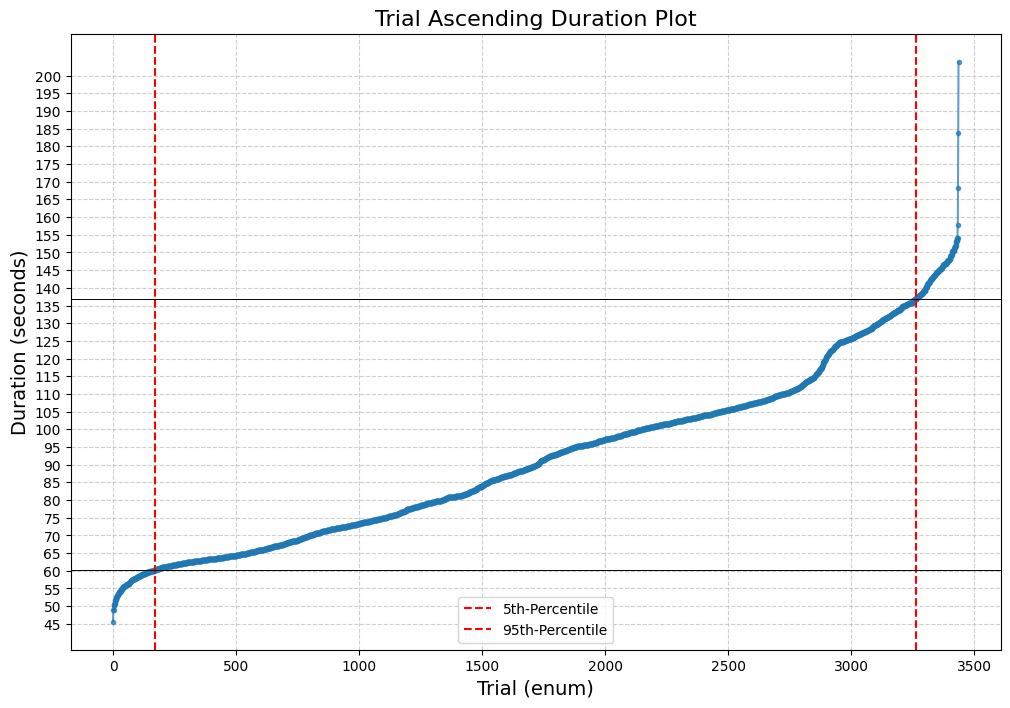

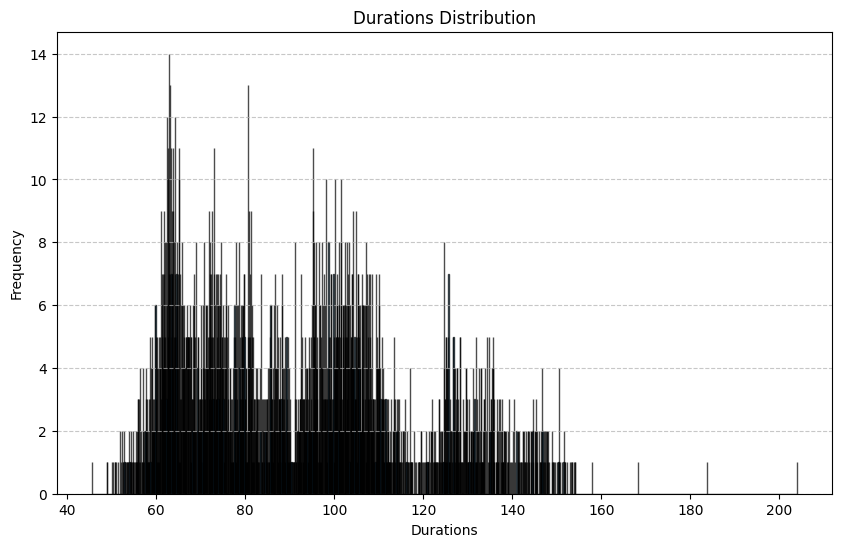

Min: 60.24
Max: 136.96
Mean: 90.99305977382876
Std: 20.936814745215713
Operation completed: 3095 files copied, 0 files missing.


In [100]:
# Directory containing the CSV files
directory = "coord_csv"  # 3628 trials - blanks (190) = 3438 valid trials

# Calculate the durations
durations_df = calculate_durations(directory)
durations_df.to_csv("ResidualProducts/trials_ascending_duration.csv", index=False)

# Display the DataFrame
print("Calculated durations:")
print(durations_df)

# Plot the distribution
plot_duration_distribution(durations_df)
plot_histogram_with_binning(durations_df, 'Durations Distribution', 'Durations', 'Frequency', 'ResidualProducts/DurationsHistogram.jpg')

# Calculate percentile thresholds
length = len(durations_df)
dur_05 = int(length * 0.05)  # 5th percentile index
dur_95 = int(length * 0.95)  # 95th percentile index

# Filter durations to exclude extreme values
durations_df = durations_df[dur_05:dur_95]

# Calculate summary statistics for the filtered DataFrame
dfmin = durations_df['Duration'].min()
dfmax = durations_df['Duration'].max()
dfmean = durations_df['Duration'].mean()
dfstd = durations_df['Duration'].std()

print(f"Min: {dfmin}\nMax: {dfmax}\nMean: {dfmean}\nStd: {dfstd}")

# Copy the files corresponding to the filtered durations
copy_files_from_dataframe(durations_df, 'coord_csv', 'ResidualProducts/csvPostDurationCleaning')


In [101]:
# Define folder paths
coord_csv_folder = 'ResidualProducts/csvPostDurationCleaning'
pupil_data_folder = 'PupilData'
output_folder = 'ResidualProducts/X-Y-Conf-Filtered'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List of files in the coord_csv folder
coord_csv_files = [f for f in os.listdir(coord_csv_folder) if f.endswith('.csv')]

for coord_file in coord_csv_files:
    # Full path of the coord_csv file
    coord_path = os.path.join(coord_csv_folder, coord_file)

    # Corresponding path in the PupilData folder
    pupil_path = os.path.join(pupil_data_folder, coord_file)

    # Check if the corresponding file exists in PupilData
    if not os.path.exists(pupil_path):
        print(f"Corresponding file not found for: {coord_file}")
        continue

    # Read the CSV files
    coord_df = pd.read_csv(coord_path)
    pupil_df = pd.read_csv(pupil_path)

    # Check if they have approximately the same number of rows
    if (len(coord_df) < (len(pupil_df) - 10)) or (len(coord_df) > (len(pupil_df) + 10)):
        print(f"Row count mismatch for {coord_file}: coord_csv ({len(coord_df)}), PupilData ({len(pupil_df)})")
        continue

    # Align the CONF value
    coord_df['CONF'] = pupil_df['CONF']
    coord_df['DIAM'] = pupil_df['DIAM']

    # Filter rows with CONF >= 0.75
    filtered_df = coord_df[coord_df['CONF'] >= 0.75][['x', 'y', 'DIAM']]

    # Save the filtered file in the output folder
    output_path = os.path.join(output_folder, coord_file)
    filtered_df.to_csv(output_path, index=False)

    print(f"File processed and saved: {output_path}")

print("Operation completed.")


File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S231_Q23.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S433_Q47.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S225_Q47.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S131_Q21.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S100_Q7.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S119_Q16.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S184_Q7.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S278_Q6.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S348_Q13.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S330_Q14.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S199_Q4.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S317_Q11.csv
File processed and saved: ResidualProducts/X-Y-Conf-Filtered/S92_Q23.csv
File processed and saved: ResidualProducts/

Calculated durations:
              File  Duration
0       S1_Q23.csv      0.08
1       S1_Q47.csv      0.08
2       S1_Q22.csv      0.08
3      S30_Q16.csv      0.16
4       S1_Q45.csv      0.24
...            ...       ...
3090  S291_Q13.csv    129.60
3091   S222_Q1.csv    129.84
3092  S332_Q22.csv    130.08
3093  S217_Q18.csv    130.32
3094  S365_Q18.csv    135.60

[3095 rows x 2 columns]


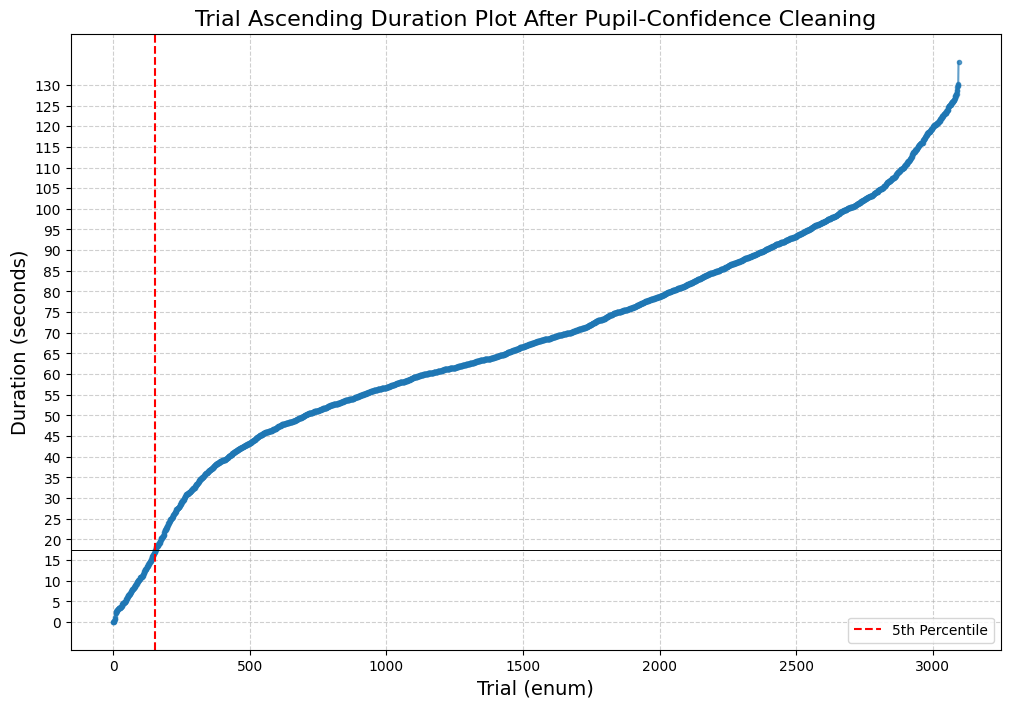

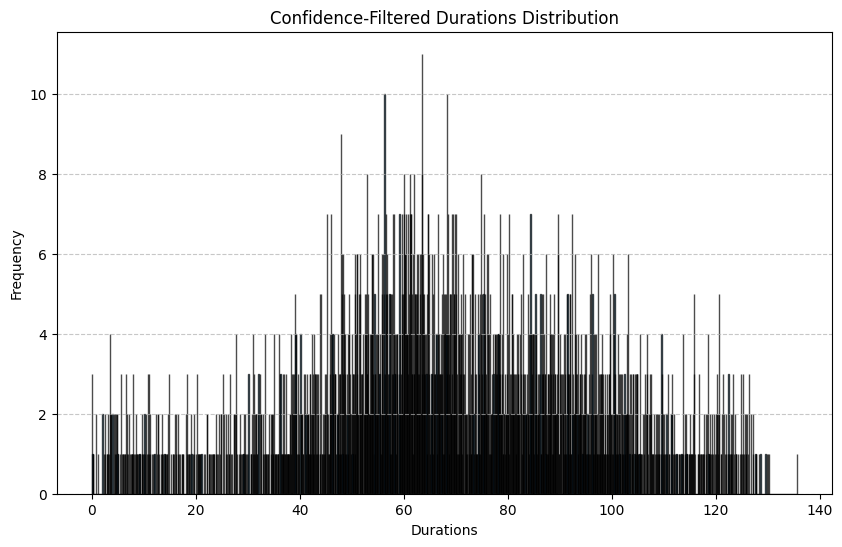

Min: 17.36
Max: 135.6
Mean: 71.62872492349541
Std: 24.183908557169126
Operation completed: 2941 files copied, 0 files missing.


In [102]:
# Directory containing the filtered X-Y data
directory = "ResidualProducts/X-Y-Conf-Filtered"

# Calculate the durations
durations_df_filt = calculate_durations(directory)
durations_df_filt.to_csv("ResidualProducts/trials_ascending_duration_conf_filtered.csv", index=False)

# Display the DataFrame
print("Calculated durations:")
print(durations_df_filt)

# Plot the distribution
plot_duration_distribution_filtered(durations_df_filt)
plot_histogram_with_binning(
    durations_df_filt,
    'Confidence-Filtered Durations Distribution',
    'Durations',
    'Frequency',
    'ResidualProducts/Histogram_Durations_Filtered.jpg'
)

# Calculate the 5th percentile index
length = len(durations_df_filt)
dur_10 = int(length * 0.05)

# Filter the DataFrame to exclude the bottom 5% of durations
durations_df_filt = durations_df_filt[dur_10:]

# Calculate statistical metrics
dfmin = durations_df_filt['Duration'].min()
dfmax = durations_df_filt['Duration'].max()
dfmean = durations_df_filt['Duration'].mean()
dfstd = durations_df_filt['Duration'].std()

# Display statistics
print(f"Min: {dfmin}\nMax: {dfmax}\nMean: {dfmean}\nStd: {dfstd}")

# Copy files corresponding to the filtered durations
copy_files_from_dataframe(
    durations_df_filt,
    'ResidualProducts/X-Y-Conf-Filtered',
    'ResidualProducts/csvPostDurationPostFilteringPostDurationCleaning'
)


S231_Q23.csv
S433_Q47.csv
S225_Q47.csv
S131_Q21.csv
S100_Q7.csv
S119_Q16.csv
S184_Q7.csv
S278_Q6.csv
S348_Q13.csv
S330_Q14.csv
S199_Q4.csv
S317_Q11.csv
S92_Q23.csv
S49_Q13.csv
S80_Q7.csv
S391_Q7.csv
S27_Q11.csv
S199_Q1.csv
S351_Q16.csv
S387_Q45.csv
S181_Q18.csv
S293_Q9.csv
S38_Q11.csv
S139_Q22.csv
S9_Q21.csv
S263_Q16.csv
S393_Q13.csv
S210_Q2.csv
S244_Q6.csv
S358_Q16.csv
S270_Q11.csv
S192_Q18.csv
S354_Q47.csv
S217_Q23.csv
S256_Q6.csv
S297_Q9.csv
S317_Q21.csv
S295_Q47.csv
S284_Q15.csv
S170_Q9.csv
S293_Q23.csv
S345_Q4.csv
S11_Q7.csv
S37_Q6.csv
S9_Q16.csv
S117_Q14.csv
S337_Q18.csv
S124_Q13.csv
S29_Q14.csv
S310_Q7.csv
S285_Q13.csv
S88_Q21.csv
S168_Q1.csv
S338_Q47.csv
S350_Q18.csv
S330_Q7.csv
S205_Q4.csv
S341_Q14.csv
S260_Q13.csv
S360_Q10.csv
S133_Q18.csv
S138_Q20.csv
S213_Q1.csv
S347_Q13.csv
S351_Q21.csv
S89_Q15.csv
S409_Q18.csv
S245_Q7.csv
S204_Q11.csv
S358_Q20.csv
S231_Q6.csv
S210_Q16.csv
S274_Q1.csv
S296_Q16.csv
S57_Q18.csv
S181_Q11.csv
S6_Q20.csv
S296_Q1.csv
S7_Q2.csv
S26_Q15.csv
S159_Q

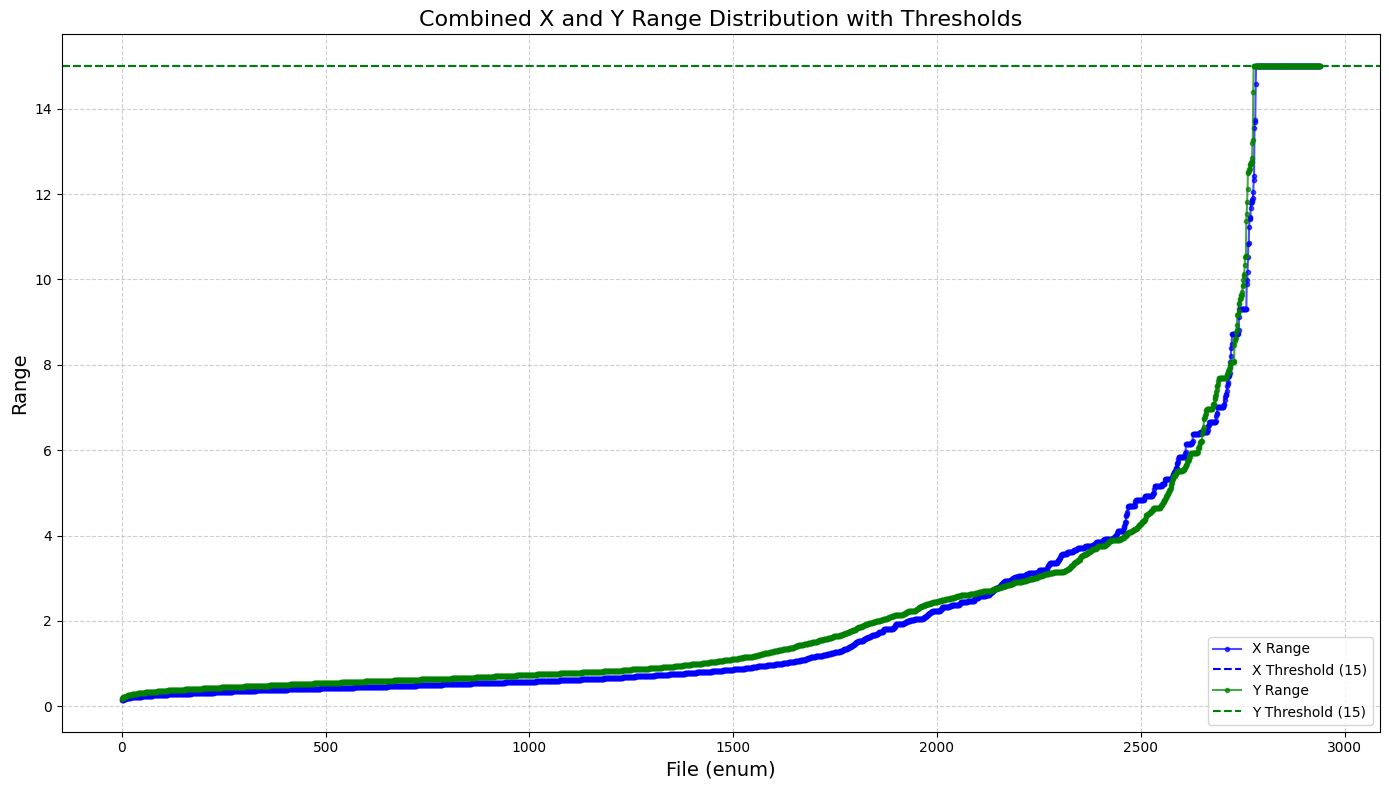

Total Files: 2941
Files cut by X threshold: 158
Files cut by Y threshold: 164
Total Files cut: 176
Total Files kept: 2783
Kept trials saved to ResidualProducts/csvPostX-Y_RangeCleaning.


In [103]:
# Path to the directory containing the cleaned CSV files
source_folder = "ResidualProducts/csvPostDurationPostFilteringPostDurationCleaning"
destination_folder = "ResidualProducts/csvPostX-Y_RangeCleaning"

range_x_df = calculate_range_x(source_folder)
ranges_y_df = calculate_range_y(source_folder)
threshold_x = 15
threshold_y = 15

# Plot the range distribution and save the histogram
# Saves also the Kept-Cut dataframe list of files
df = plot_combined_range_distribution(range_x_df, ranges_y_df, threshold_x, threshold_y)

# Ensure the destination folder exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate over the kept trials
kept_trials = df[df['Status'] == 'Kept']
for trial in kept_trials['File']:
    source_file = os.path.join(source_folder, f"{trial}")
    destination_file = os.path.join(destination_folder, f"{trial}")

    # Copy the file if it exists
    if os.path.exists(source_file):
        shutil.copy(source_file, destination_file)
    else:
        print(f"Source file {source_file} not found.")

print(f"Kept trials saved to {destination_folder}.")


In [104]:
directory = "ResidualProducts/csvPostX-Y_RangeCleaning"
destination_folder = "ResidualProducts/Fixations-PreProcessing"

# Ensure the destination folder exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

for file in os.listdir(directory):
    if file.endswith(".csv"):
        try:
            # Parse subject ID and trial ID from the file name (format: S$s_Q$q.csv)
            parts = file.split('_')
            subject_id = parts[0][1:]  # Extract the subject ID (e.g., "S1" -> "1")
            trial_id = parts[1][1:-4]  # Extract the trial ID (e.g., "Q2.csv" -> "2")

            # Load the dataframe for the current trial
            dt = pd.read_csv(os.path.join(directory, file))

            # Calculate the standard deviations for x and y
            rng_x = dt['x'].max() - dt['x'].min()
            rng_y = dt['y'].max() - dt['y'].min()

            # Define thresholds for dispersion and duration
            dispersion_threshold = math.sqrt((rng_x / 20) ** 2 + (rng_y / 20) ** 2) / 2
            duration_threshold = 8

            # Calculate fixations on the dataset
            fixations = calculate_fixations(dt, max_dispersion=dispersion_threshold, min_duration_points=duration_threshold)

            # Analyze the fixation list and save the resulting DataFrame
            df, _ = analyze_list(fixations)

            # Save the analyzed data to the destination folder
            df.to_csv(os.path.join(destination_folder, file), index=False)

            print(f'Processed file: Subject {subject_id}, Trial {trial_id}')
        except Exception as e:
            print(f'Error processing file {file}: {e}')

Processed file: Subject 231, Trial 23
Processed file: Subject 433, Trial 47
Processed file: Subject 225, Trial 47
Processed file: Subject 131, Trial 21
Processed file: Subject 100, Trial 7
Processed file: Subject 119, Trial 16
Processed file: Subject 184, Trial 7
Processed file: Subject 278, Trial 6
Processed file: Subject 348, Trial 13
Processed file: Subject 330, Trial 14
Processed file: Subject 199, Trial 4
Processed file: Subject 317, Trial 11
Processed file: Subject 92, Trial 23
Error processing file S49_Q13.csv: 'NoneType' object has no attribute 'to_csv'
Processed file: Subject 80, Trial 7
Processed file: Subject 391, Trial 7
Processed file: Subject 27, Trial 11
Processed file: Subject 199, Trial 1
Processed file: Subject 351, Trial 16
Processed file: Subject 387, Trial 45
Processed file: Subject 181, Trial 18
Processed file: Subject 293, Trial 9
Processed file: Subject 38, Trial 11
Processed file: Subject 139, Trial 22
Processed file: Subject 9, Trial 21
Processed file: Subject

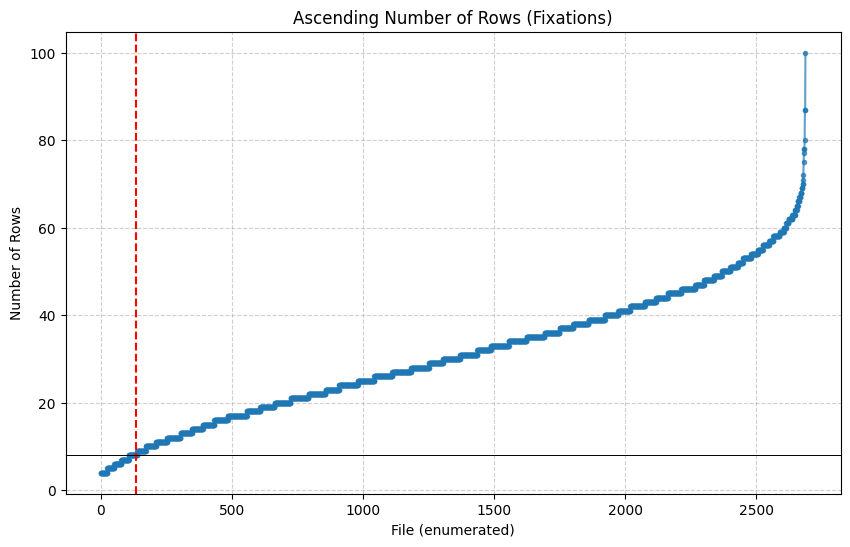

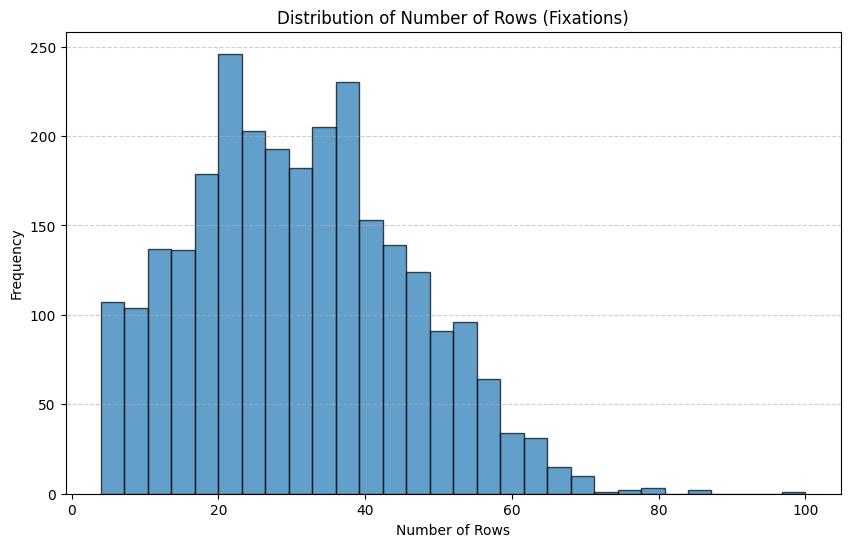

In [105]:
# Directory containing the CSV files
csv_folder = "ResidualProducts/Fixations-PreProcessing"

# List to collect file information
file_data = []

# Iterate through all files in the directory
for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        try:
            # Full file path
            file_path = os.path.join(csv_folder, file)

            # Read the CSV file and count the number of rows
            df = pd.read_csv(file_path)
            n_rows = len(df)  # Count the rows in the DataFrame

            # Append the filename and row count to the list
            file_data.append({"Filename": file, "NFixations": n_rows})
        except Exception as e:
            print(f"Error processing file {file}: {e}")

# Create a DataFrame from the collected data
results_df = pd.DataFrame(file_data)

# Sort the DataFrame by the number of rows in ascending order
results_df = results_df.sort_values(by="NFixations").reset_index(drop=True)

# Save the DataFrame to a CSV file (optional)
results_df.to_csv("ResidualProducts/file_row_counts.csv", index=False)

# Plot 1: Ascending number of rows
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_df)), results_df["NFixations"], marker='.', alpha=0.7)

'''TODO Da concordare con Guido:
Tagliare le istanze che hanno un nuero di fixations inferiore a sqrt(#AOI_mean(on that painting))'''

length = len(results_df)
dur_5 = int(length * 0.05)  # Calculate the index corresponding to the 5th percentile of the data

# Find the y-value (number of fixations) at the 5th percentile index
y_5th = results_df['NFixations'].iloc[dur_5]

# Draw a vertical line at the 5th percentile to indicate its position
plt.axvline(x=dur_5, color='red', linestyle='--', label='5th-Percentile')

# Draw thin black horizontal lines at the y-value of the 5th percentile
plt.axhline(y=y_5th, color='black', linestyle='-', linewidth=0.7)


plt.title("Ascending Number of Rows (Fixations)")
plt.xlabel("File (enumerated)")
plt.ylabel("Number of Rows")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("ResidualProducts/Ascending_NFixations_Plot.jpg")
plt.show()

# Plot 2: Distribution of the number of rows
plt.figure(figsize=(10, 6))
plt.hist(results_df["NFixations"], bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Rows (Fixations)")
plt.xlabel("Number of Rows")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("ResidualProducts/NFixations_Distribution.jpg")
plt.show()


In [106]:
length = len(results_df)
ran_05 = int(length*0.05)
results_df = results_df[ran_05:]
dfmin = results_df['NFixations'].min()
dfmax = results_df['NFixations'].max()
dfmean = results_df['NFixations'].mean()
dfstd = results_df['NFixations'].std()
print(f'Min: {dfmin}\nMax: {dfmax}\nMean: {dfmean}\nStd: {dfstd}')

results_df.to_csv("ResidualProducts/SelectedForMachineLearning.csv")

Min: 8
Max: 100
Mean: 32.312451057165234
Std: 14.0226533758532


In [109]:
folder_path = "ResidualProducts/Fixations-PreProcessing/"

# Initialize an empty list to store the extracted features
final_features = []

# Name of the CSV file containing the selected trials
selected_csv = 'ResidualProducts/SelectedForMachineLearning.csv'

# Read the CSV file into a DataFrame
selected_df = pd.read_csv(selected_csv)

# Extract 'ID' and 'PAINTING' from the 'File' column using regex
selected_df['ID'] = selected_df['Filename'].apply(lambda x: int(re.search(r'S(\d+)_Q(\d+)\.csv', x).group(1)))
selected_df['PAINTING'] = selected_df['Filename'].apply(lambda x: int(re.search(r'S(\d+)_Q(\d+)\.csv', x).group(2)))

# Keep only the 'ID' and 'PAINTING' columns
selected_df = selected_df[['ID', 'PAINTING']]

# Print the number of rows in the DataFrame
print(len(selected_df))

# Iterate through each (ID, PAINTING) pair in the DataFrame
for _, row in selected_df.iterrows():
    s = row['ID']  # Extract the ID
    q = row['PAINTING']  # Extract the PAINTING

    # Construct the filename for the corresponding trial
    file_name = f"{folder_path}S{s}_Q{q}.csv"
    try:
        # Read the trial data from the CSV file
        trial_data = pd.read_csv(file_name)

        # Extract features using the defined functions
        static_gaze_features = extract_static_gaze_features(trial_data)
        static_pupil_features = extract_static_pupil_features(trial_data)
        dynamic_gaze_features = extract_dynamic_gaze_features(trial_data)

        # Combine all extracted features into a single dictionary
        combined_features = {
            "ID": s,  # Include the ID
            "PAINTING": q,  # Include the PAINTING
            **static_gaze_features,  # Add static gaze features
            **static_pupil_features,  # Add static pupil features
            **dynamic_gaze_features  # Add dynamic gaze features
        }

        # Append the combined features to the final features list
        final_features.append(combined_features)

        # Print the progress for the current trial
        print(f'{s},{q}')

    # Handle exceptions if the file processing fails
    except Exception as e:
        print(f'{s},{q} failed: {e}')

# Convert the final features list into a DataFrame
final_dataset = pd.DataFrame(final_features)

# Save the final dataset to a CSV file
final_dataset.to_csv("ResidualProducts/final_features_dataset.csv", index=False)


2554
7,20
244,10
49,9
337,18
244,20
244,11
376,21
119,2
311,15
132,20
28,14
413,18
88,2
310,15
86,23
278,20
371,11
77,4
326,14
376,14
183,7
88,9
8,15
244,1
204,2
175,4
204,18
371,21
139,22
8,16
244,15
339,16
211,20
119,20
175,21
339,20
132,14
280,4
345,47
244,7
257,47
376,45
117,11
85,23
198,22
193,47
7,11
413,16
198,14
2,13
193,1
204,11
200,20
85,11
387,23
124,11
216,1
199,11
207,20
332,22
204,4
204,9
85,15
119,10
371,18
271,16
193,13
277,20
198,11
354,14
165,15
376,1
198,16
278,6
376,4
345,6
1,4
410,7
121,20
244,14
207,15
7,1
351,13
277,7
193,20
351,9
371,16
175,15
77,2
310,18
52,6
231,15
139,15
121,10
174,20
394,20
198,15
206,22
216,15
280,9
206,10
351,6
77,1
280,20
92,2
376,9
119,15
198,47
85,6
159,7
330,14
49,2
52,14
7,9
147,16
119,4
183,23
121,7
244,4
270,15
295,20
339,47
310,21
270,20
198,18
91,6
331,16
216,4
330,20
2,21
198,21
8,11
371,45
61,6
54,21
337,16
264,22
339,18
8,47
339,14
7,23
256,2
339,21
207,13
29,7
211,2
175,23
197,9
332,14
277,6
279,22
256,13
345,18
345,11
311,14


In [110]:
# Define the paths to the input files
features_file = "ResidualProducts/final_features_dataset.csv"
votes_file = "votes_dataset.csv"

# Load the datasets
features_df = pd.read_csv(features_file)
votes_df = pd.read_csv(votes_file)

# Merge the datasets on the common columns 'ID' and 'PAINTING'
mapped_df = pd.merge(features_df, votes_df, on=["ID", "PAINTING"], how="inner")

# Save the merged dataset to a new CSV file
mapped_df.to_csv("ResidualProducts/ID-Features-Vote.csv", index=False)

print("CSV file 'ID-Features-Vote.csv' created successfully!")

CSV file 'ID-Features-Vote.csv' created successfully!


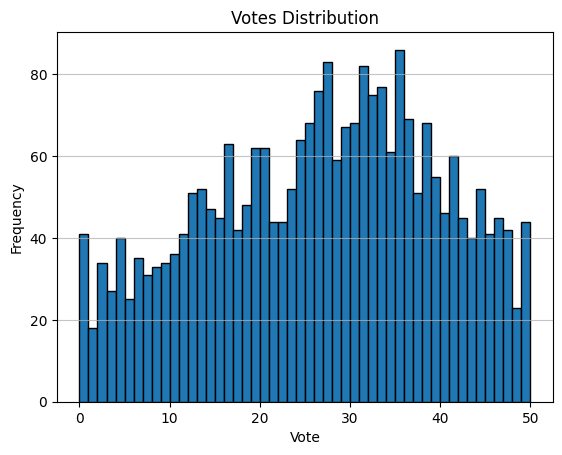

In [115]:
file_path = 'ResidualProducts/ID-Features-Vote.csv'
data = pd.read_csv(file_path)

# Controlla se la colonna 'voto' esiste
if 'vote' in data.columns:
    # Crea l'istogramma
    plt.hist(data['vote'], bins=range(0, 51, 1), edgecolor='black')
    plt.title('Votes Distribution')
    plt.xlabel('Vote')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.savefig('ResidualProducts/Selected-Trials_Vote-Distribution.jpg')
    plt.show()
else:
    print("La colonna 'voto' non è presente nel dataset.")

In [116]:
final_dataset = pd.read_csv('ResidualProducts/ID-Features-Vote.csv')

                                     Feature  Variance
36   is_max_dilatation_in_last_instance_area  0.167696
17                    last_is_most_fixations  0.140850
16                  last_is_longest_duration  0.136405
15                   first_is_most_fixations  0.130520
14                 first_is_longest_duration  0.109050
35  is_max_dilatation_in_first_instance_area  0.084536
18                  total_duration_fixations  0.056362
6                         area_duration_mean  0.051931
1                          areas_of_interest  0.040200
23                            min_dilatation  0.035887
12                      last_series_duration  0.033411
28         instance_area_mean_dilatation_max  0.031213
5                          area_duration_max  0.031055
4                          area_duration_min  0.030833
32                      dilatation_range_max  0.029050
40         initial_instance_area_duration_ms  0.028697
25                           mean_dilatation  0.028568
24        

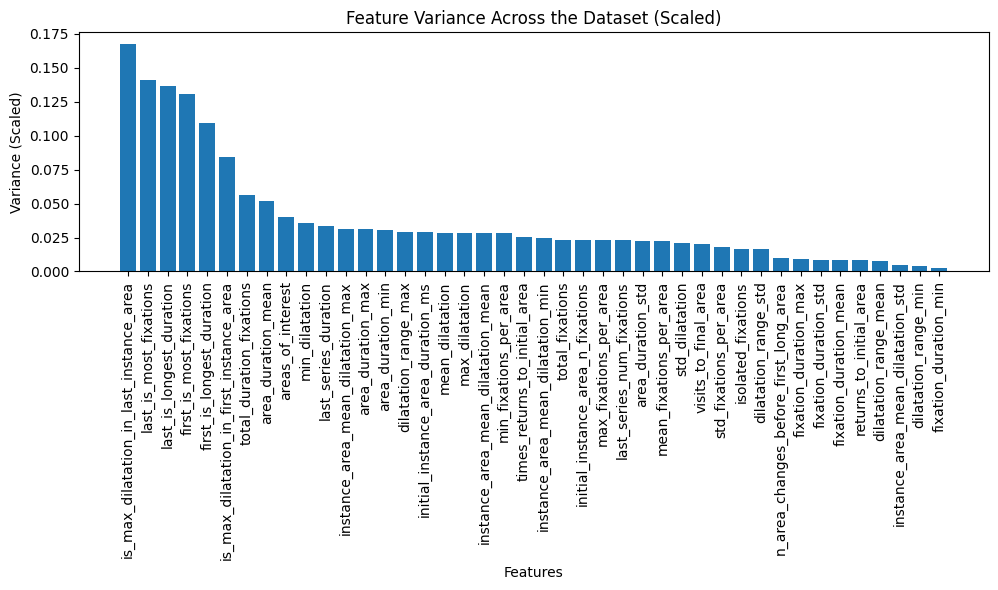

In [118]:
# Exclude non-numeric columns like "ID" and "PAINTING"
numeric_features = final_dataset.drop(columns=["ID", "PAINTING", "vote"])

# Normalization with Min-Max Scaling (range 0-1)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Create a new DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features.columns)

# Compute the variance of each scaled feature
feature_variance = scaled_df.var()

# Create a DataFrame for the variances
variance_df = pd.DataFrame({
    "Feature": feature_variance.index,
    "Variance": feature_variance.values
})

# Sort the DataFrame by variance in descending order
variance_df = variance_df.sort_values(by="Variance", ascending=False)

# Display the sorted DataFrame
print(variance_df)
variance_df.to_csv('ResidualProducts/variances.csv', index=False)

# Visualization with a bar chart
plt.figure(figsize=(10, 6))
plt.bar(variance_df["Feature"], variance_df["Variance"])
plt.xlabel("Features")
plt.ylabel("Variance (Scaled)")
plt.title("Feature Variance Across the Dataset (Scaled)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('ResidualProducts/VarianceChart.png')
plt.show()


In [119]:
# Use the final dataset as the source
features_df = final_dataset

# Exclude the ID and PAINTING columns from analysis
columns_to_analyze = [col for col in features_df.columns if col not in ['ID', 'PAINTING']]

# List to store the results
results = []

# Calculate statistics for each column
for col in columns_to_analyze:
    feature_data = features_df[col].dropna()  # Remove NaN values
    min_val = feature_data.min()  # Minimum value
    max_val = feature_data.max()  # Maximum value
    mean_val = feature_data.mean()  # Mean value
    std_val = feature_data.std()  # Standard deviation
    var_val = feature_data.var()  # Variance
    
    # Perform Shapiro-Wilk normality test
    try:
        shapiro_stat, shapiro_p = shapiro(feature_data)
        normality = 'Normal' if shapiro_p > 0.05 else 'Not Normal'
    except ValueError:
        # Handle cases with insufficient data for the test
        shapiro_stat, shapiro_p, normality = None, None, 'Insufficient Data'

    # Add the results to the list
    results.append({
        'Feature': col,
        'Min': min_val,
        'Max': max_val,
        'Mean': mean_val,
        'Std': std_val,
        'Variance': var_val,
        'Shapiro-Wilk Stat': shapiro_stat,
        'Shapiro-Wilk p-value': shapiro_p,
        'Normality': normality
    })

# Create a DataFrame from the results
stats_df = pd.DataFrame(results)

# Save the results to a new CSV file
stats_df.to_csv('ResidualProducts/features_statistics.csv', index=False)

print("Analysis complete. Results saved to 'features_statistics.csv'.")


Analysis complete. Results saved to 'features_statistics.csv'.


In [ ]:
# Lista delle features da mettere in grassetto
'''highlight_features = [
    'areas_of_interest', 'area_duration_ms_min', 'area_duration_ms_std', 'instance_area_duration_mean',
    'instance_area_fixations_min', 'instance_area_fixations_max', 'instance_area_fixations_mean',
    'instance_area_fixations_std', 'final_instance_area_duration_ms', 'is_initial_instance_area_longest_duration',
    'min_dilatation', 'max_dilatation', 'mean_dilatation', 'std_dilatation', 'instance_area_mean_dilatation_min',
    'instance_area_mean_dilatation_max', 'instance_area_mean_dilatation_std', 'dilatation_range_max',
    'is_max_dilatation_in_last_instance_area', 'returns_to_initial_area', 'n_area_changes_before_first_long_area',
    'initial_instance_area__duration_ms', 'initial_instance_area_n_fixations'
]

# Supponiamo di avere il dataset caricato in `final_dataset`
# Escludi colonne non numeriche come "ID" e "PAINTING"
numeric_features = final_dataset.drop(columns=["ID", "PAINTING", 'voto'])

# Rimuovi le feature binarie
non_binary_features = numeric_features.loc[:, numeric_features.nunique() > 2]

# Normalizzazione con Min-Max Scaling (range 0-1)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(non_binary_features)

# Crea un nuovo DataFrame con le features scalate
scaled_df = pd.DataFrame(scaled_features, columns=non_binary_features.columns)

# Calcola la varianza di ogni feature scalata
feature_variance = scaled_df.var()

# Crea un DataFrame per le varianze
variance_df = pd.DataFrame({
    "Feature": feature_variance.index,
    "Variance": feature_variance.values
})

# Ordina il DataFrame per varianza in ordine decrescente
variance_df = variance_df.sort_values(by="Variance", ascending=False)

# Visualizza il DataFrame ordinato
print(variance_df)
variance_df.to_csv('varianze.csv', index=False)

# Visualizzazione con istogramma
plt.figure(figsize=(10, 6))
for feature, variance in zip(variance_df["Feature"], variance_df["Variance"]):
    plt.bar(feature, variance, color='black')

plt.xlabel("Features")
plt.ylabel("Variance (Scaled)")
plt.title("Feature Variance Across the Dataset (Scaled)")

xticks = plt.xticks(rotation=90)[1]
for xtick in xticks:
    if xtick.get_text() in highlight_features:
        xtick.set_fontweight('bold')

plt.tight_layout()
plt.savefig('GraficoVarianze.png')
plt.show()'''


In [ ]:
'''import matplotlib.pyplot as plt
import pandas as pd
import math


# Supponiamo di avere il dataset caricato in `final_dataset`
# Escludi colonne non numeriche come "ID" e "PAINTING"
numeric_features = final_dataset.drop(columns=["ID", "PAINTING", 'voto'])

# Seleziona solo le feature binarie
binary_features = numeric_features.loc[:, numeric_features.nunique() == 2]

# Calcola la percentuale di 1 per ogni feature binaria
binary_percentage =  1- (binary_features.sum() / binary_features.shape[0])

for i in range(0,len(binary_percentage)-1):
    binary_percentage[i] = 1 - math.sqrt(binary_percentage[i])


# Visualizzazione delle feature binarie come percentuale di 1
plt.figure(figsize=(10, 6))
plt.bar(binary_percentage.index, binary_percentage.values, color='black')
plt.xlabel("Binary Features")
plt.ylabel("Squared Ratio of 0s")
plt.title("Squared Ratio of 0s in Binary Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('PercentualeBinarie.png')
plt.show()

# Stampa i risultati
print(binary_percentage.sort_values(ascending=False))'''


Genetic Algorithms

In [120]:
# Define the binarization windows
binarization_windows = [
    ([0, 25], [26, 50]),
    ([0, 21], [32, 50]),
    ([0, 16], [37, 50]),
    ([0, 11], [42, 50])
]

# Load the dataset
file_path = "ResidualProducts/ID-Features-Vote.csv"
dataset = pd.read_csv(file_path)

# Genetic Algorithm Configuration
num_generations = 100
num_features = len(dataset.columns) - 3  # Excluding ID, PAINTING, and vote
population_size = 50

# Define genetic algorithm evaluation function
def evaluate_individual(individual, X, y):
    selected_features = [bool(gene) for gene in individual]
    if sum(selected_features) == 0:
        return 0.0  # Avoid empty feature sets

    X_selected = X[:, selected_features]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    scores = cross_val_score(clf, X_selected, y, cv=skf, scoring="accuracy")
    return np.mean(scores),

# Iterate through each binarization window
for idx, (class_0_range, class_1_range) in enumerate(binarization_windows):
    print(f"Processing binarization window {idx + 1}: 0->{class_0_range}, 1->{class_1_range}")

    # Binarize the target column
    def binarize_vote(vote):
        if class_0_range[0] <= vote <= class_0_range[1]:
            return 0
        elif class_1_range[0] <= vote <= class_1_range[1]:
            return 1
        else:
            return None

    dataset[f"binary_vote_{idx}"] = dataset["vote"].apply(binarize_vote)

    # Filter out rows with None in the binary target
    filtered_dataset = dataset.dropna(subset=[f"binary_vote_{idx}"])
    filtered_dataset[f"binary_vote_{idx}"] = filtered_dataset[f"binary_vote_{idx}"].astype(int)

    # Get the feature matrix and target vector
    X = filtered_dataset.drop(columns=["ID", "PAINTING", "vote", f"binary_vote_{idx}"]).values
    y = filtered_dataset[f"binary_vote_{idx}"].values

    # Print dataset balance
    print("Class distribution before balancing:")
    print(filtered_dataset[f"binary_vote_{idx}"].value_counts())

    # Downsample the majority class
    class_counts = filtered_dataset[f"binary_vote_{idx}"].value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    minority_data = filtered_dataset[filtered_dataset[f"binary_vote_{idx}"] == minority_class]
    majority_data = filtered_dataset[filtered_dataset[f"binary_vote_{idx}"] == majority_class]
    majority_downsampled = majority_data.sample(len(minority_data), random_state=42)
    balanced_dataset = pd.concat([minority_data, majority_downsampled]).sample(frac=1, random_state=42)

    X_balanced = balanced_dataset.drop(columns=["ID", "PAINTING", "vote", f"binary_vote_{idx}"]).values
    y_balanced = balanced_dataset[f"binary_vote_{idx}"].values

    # Print balanced dataset
    print("Class distribution after balancing:")
    print(balanced_dataset[f"binary_vote_{idx}"].value_counts())

    # Genetic Algorithm Setup
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate_individual, X=X_balanced, y=y_balanced)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Initialize population
    population = toolbox.population(n=population_size)

    # Run the genetic algorithm
    hall_of_fame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, log = algorithms.eaSimple(
        population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations,
        stats=stats, halloffame=hall_of_fame, verbose=True
    )

    # Extract the best individual
    best_individual = hall_of_fame[0]
    selected_features = [i for i, gene in enumerate(best_individual) if gene == 1]

    # Train the final model using the best feature set
    X_selected = X_balanced[:, selected_features]
    final_model = RandomForestClassifier(random_state=42)
    final_model.fit(X_selected, y_balanced)

    # Evaluate the model
    y_pred = final_model.predict(X_selected)
    accuracy = accuracy_score(y_balanced, y_pred)
    sensitivity = recall_score(y_balanced, y_pred, pos_label=1)
    specificity = recall_score(y_balanced, y_pred, pos_label=0)
    precision = precision_score(y_balanced, y_pred, pos_label=1)
    confusion = confusion_matrix(y_balanced, y_pred)

    npv = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1]) if (confusion[0, 0] + confusion[0, 1]) > 0 else 0

    # Save the model and results
    model_file = f"ResidualProducts/final_model_window_{idx + 1}.pkl"
    with open(model_file, "wb") as f:
        pickle.dump(final_model, f)

    print(f"Binarization Window {idx + 1} Results:")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")
    print(f"NPV: {npv}")
    print(f"Selected Features: {selected_features}")

    # Plot generation performance
    gen = log.select("gen")
    avg = log.select("avg")
    max_ = log.select("max")

    plt.figure()
    plt.plot(gen, avg, label="Average Fitness")
    plt.plot(gen, max_, label="Max Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"Genetic Algorithm Performance for Window {idx + 1}")
    plt.legend()
    plt.savefig(f"ResidualProducts/genetic_algorithm_performance_window_{idx + 1}.png")
    plt.show()


Processing binarization window 1: 0->[0, 25], 1->[26, 50]
Class distribution before balancing:
binary_vote_0
1    1415
0    1139
Name: count, dtype: int64
Class distribution after balancing:
binary_vote_0
0    1139
1    1139
Name: count, dtype: int64


KeyboardInterrupt: 